# Deep Learning with custom data set

In [1]:
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

CAT SHAPE :  (375, 500, 3)


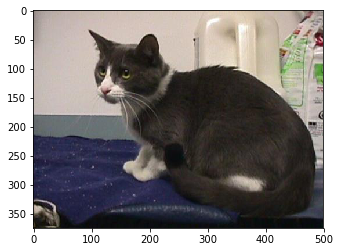

In [2]:
cat4 = cv2.imread('../../CATS_DOGS/train/CAT/4.jpg')
cat4 = cv2.cvtColor(cat4, cv2.COLOR_BGR2RGB)

print('CAT SHAPE : ', cat4.shape)
plt.imshow(cat4)

DOG SHAPE :  (288, 300, 3)


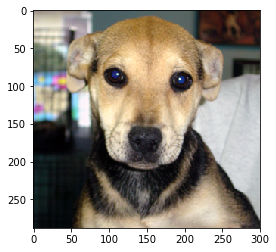

In [3]:
dog4 = cv2.imread('../../CATS_DOGS/train/DOG/4.jpg')
dog4 = cv2.cvtColor(dog4, cv2.COLOR_BGR2RGB)

print('DOG SHAPE : ', dog4.shape)
plt.imshow(dog4)

## Batch Processing

일반적으로, 실제로 존재하는 이미지 파일은 수 GB가 넘기 때문에 직접적으로 불러와서 사용을 하기에는 무리가 있을 수 있습니다. <br>
따라서 Keras 안에 있는 Batch Proccesing과 관련된 기능을 사용하여 이를 해결할 수 있습니다.

### RIG : Random Image Generator

In [4]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [5]:
image_gen = ImageDataGenerator(
    rotation_range = 30,       # `랜덤 회전값`
    width_shift_range = 0.1,   # `랜덤 수평 이동값`
    height_shift_range = 0.1,  # `랜덤 수직 이동값`
    rescale = 1/255,           # Nomalization
    shear_range = 0.2,         # `랜덤 이미지 절단값`
    zoom_range = 0.2,          # `랜덤 확대값`
    horizontal_flip = True,    # `수평 뒤집기`
    fill_mode = 'nearest'      # `빈값 채우기`
)

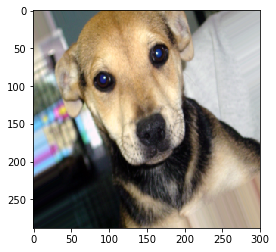

In [6]:
plt.imshow(image_gen.random_transform(dog4))

### Set-up file path in RIG

'../../CATS/DOGS/train' 안에는 다음과 같은 폴더 구조가 있습니다.

1. CATS
2. DOGS

각각의 폴더명이 **Classname**으로 지정이 되며, 해당 경로에는 이와 일치하는 **Image Files**이 저장되어 있습니다.

In [7]:
image_gen.flow_from_directory('../../CATS_DOGS/train')

Found 18743 images belonging to 2 classes.


### Load model

앞서 MNIST, CIFAR-10에 관련된 세 가지 실습을 진행하였습니다.<br>
이 경우에서는 직접 모델을 학습시켜서 사용했으나, 이번 예제의 경우 **N 시간의 모델 학습 시간**이 소요될 것입니다.<br>
따라서, 미리 fitting된 model을 불러들여서 사용하도록 하겠습니다.

> 또한 Keras@2.2에서는 몇몇 새로운 릴리즈의 import module이 생겨났기 때문에, 이를 반영했습니다. <br>
> 가장 대표적인 차이는 MaxPool2D 가 MaxPooling2D로 변경된 부분이라고 할 수 있습니다. <br>
> 하지만, 기능적으로 동질하기 때문에 이름만 달라졌다고 생각하셔도 문제 없을 것 같습니다.

In [8]:
from keras.models import Sequential

In [9]:
from keras.layers import Activation, Dropout, Flatten, Conv2D, MaxPooling2D, Dense

In [10]:
# VARIABLES
input_shape = (150, 150, 3)

# MODELS
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3, 3), input_shape = (150, 150, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(filters = 32, kernel_size = (3, 3), input_shape = (150, 150, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(filters = 32, kernel_size = (3, 3), input_shape = (150, 150, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))


model.add(Flatten())

model.add(Dense(120))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(1)) # 이진법 타켓 Dog 0 Cat 1
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9248)              0         
__________

### Decide the batch size

In [11]:
batch_size = 16

train_image_gen = image_gen.flow_from_directory(
    '../../CATS_DOGS/train',
    target_size = input_shape[:2],
    batch_size = batch_size,
    class_mode = 'binary'
)

Found 18743 images belonging to 2 classes.


In [12]:
test_image_gen = image_gen.flow_from_directory(
    '../../CATS_DOGS/test',
    target_size = input_shape[:2],
    batch_size = batch_size,
    class_mode = 'binary'
)

Found 6251 images belonging to 2 classes.


In [13]:
print(train_image_gen.class_indices, test_image_gen.class_indices)

{'CAT': 0, 'DOG': 1} {'CAT': 0, 'DOG': 1}


### Sample Model Fitting

In [14]:
results = model.fit_generator(
    train_image_gen,
    epochs = 10,
    steps_per_epoch = 150,   # Epochs 당 허락할 스탭
    validation_data = test_image_gen,
    validation_steps = 12
)

Epoch 1/10
150/150 [==============================] - 78s 521ms/step - loss: 0.6945 - acc: 0.5112 - val_loss: 0.6894 - val_acc: 0.5550
Epoch 2/10
150/150 [==============================] - 77s 511ms/step - loss: 0.6843 - acc: 0.5658 - val_loss: 0.6819 - val_acc: 0.5591
Epoch 3/10
 53/150 [=========>....................] - ETA: 19s - loss: 0.6836 - acc: 0.5637

C:\Users\USER\anaconda3\envs\python-cvcourse\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 209715200 bytes but only got 0. Skipping tag 48
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\USER\anaconda3\envs\python-cvcourse\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 52428800 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\USER\anaconda3\envs\python-cvcourse\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6468665344 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\USER\anaconda3\envs\python-cvcourse\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 7027. Skipping tag 48
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\USER\ana

 93/150 [=================>............] - ETA: 11s - loss: 0.6865 - acc: 0.5477

C:\Users\USER\anaconda3\envs\python-cvcourse\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\USER\anaconda3\envs\python-cvcourse\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404094976 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\USER\anaconda3\envs\python-cvcourse\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404619264 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\USER\anaconda3\envs\python-cvcourse\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 425459712 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\USER\anacon

138/150 [==========================>...] - ETA: 2s - loss: 0.6859 - acc: 0.5512

C:\Users\USER\anaconda3\envs\python-cvcourse\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262146 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\USER\anaconda3\envs\python-cvcourse\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262151 bytes but only got 0. Skipping tag 56
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\USER\anaconda3\envs\python-cvcourse\lib\site-packages\PIL\TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 0. 
  warnings.warn(str(msg))


150/150 [==============================] - 77s 511ms/step - loss: 0.6852 - acc: 0.5558 - val_loss: 0.6835 - val_acc: 0.5647
Epoch 4/10
 23/150 [===>..........................] - ETA: 22s - loss: 0.6906 - acc: 0.5571

C:\Users\USER\anaconda3\envs\python-cvcourse\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18350080 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\USER\anaconda3\envs\python-cvcourse\lib\site-packages\PIL\TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))


150/150 [==============================] - 77s 516ms/step - loss: 0.6831 - acc: 0.5554 - val_loss: 0.6777 - val_acc: 0.5590
Epoch 5/10
150/150 [==============================] - 78s 518ms/step - loss: 0.6784 - acc: 0.5837 - val_loss: 0.6720 - val_acc: 0.5804
Epoch 6/10
 14/150 [=>............................] - ETA: 25s - loss: 0.6656 - acc: 0.5536

C:\Users\USER\anaconda3\envs\python-cvcourse\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307363840 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\USER\anaconda3\envs\python-cvcourse\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307888128 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\USER\anaconda3\envs\python-cvcourse\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 328728576 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\USER\anaconda3\envs\python-cvcourse\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1385474 bytes but only got 5357. Skipping tag 513
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\USER\ana

 82/150 [===============>..............] - ETA: 14s - loss: 0.6716 - acc: 0.5777

C:\Users\USER\anaconda3\envs\python-cvcourse\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\USER\anaconda3\envs\python-cvcourse\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\USER\anaconda3\envs\python-cvcourse\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\USER\anaconda3\envs\python-cvcourse\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\USER\anaconda3\envs\python-cvcours

150/150 [==============================] - 77s 515ms/step - loss: 0.6718 - acc: 0.5863 - val_loss: 0.6701 - val_acc: 0.5967
Epoch 7/10
 67/150 [============>.................] - ETA: 16s - loss: 0.6802 - acc: 0.5774

C:\Users\USER\anaconda3\envs\python-cvcourse\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6553600 bytes but only got 0. Skipping tag 49
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\USER\anaconda3\envs\python-cvcourse\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 4951. Skipping tag 51
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\USER\anaconda3\envs\python-cvcourse\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293339136 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\USER\anaconda3\envs\python-cvcourse\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293863424 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\USER\anaco

150/150 [==============================] - 77s 511ms/step - loss: 0.6746 - acc: 0.5884 - val_loss: 0.6546 - val_acc: 0.6119
Epoch 8/10
150/150 [==============================] - 76s 504ms/step - loss: 0.6767 - acc: 0.5879 - val_loss: 0.6553 - val_acc: 0.6178
Epoch 9/10
150/150 [==============================] - 72s 482ms/step - loss: 0.6551 - acc: 0.6158 - val_loss: 0.6453 - val_acc: 0.6313
Epoch 10/10
150/150 [==============================] - 72s 480ms/step - loss: 0.6485 - acc: 0.6367 - val_loss: 0.6241 - val_acc: 0.6562


> 위에서 뜬 에러는 특정한 이미지를 읽을 수 없다는 에러입니다. <br>
> 무시하셔도 되지만, 보고 싶지 않다면 다음의 구문을 추가하는 것으로 해결할 수 있기는 합니다. <br>
> ```
> import warnings
> warnings.filterwarnings('ignore')
> ```

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
results.history['acc']s

[0.51125,
 0.5658333333333333,
 0.5558333333333333,
 0.5554166666666667,
 0.58375,
 0.58625,
 0.5884567127473083,
 0.5879166666666666,
 0.6158333333333333,
 0.6369719783265637]

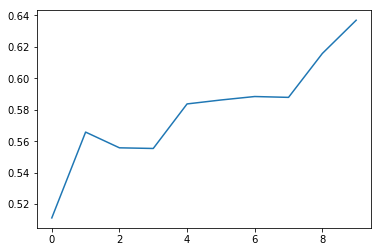

In [17]:
plt.plot(results.history['acc'])

In [18]:
from keras.models import load_model

In [19]:
new_model = load_model('cat_dog_100epochs.h5')

In [31]:
dog_file = '../../CATS_DOGS/test/DOG/10001.jpg'

from keras.preprocessing import image

In [32]:
dog_img = image.load_img(dog_file, target_size = (150, 150))
dog_img = image.img_to_array(dog_img)
dog_img.shape

(150, 150, 3)

### Reshape for numpy

In [33]:
import numpy as np

dog_img = np.expand_dims(dog_img, axis=0)
dog_img.shape

(1, 150, 150, 3)

In [34]:
dog_img = dog_img / 255

In [39]:
print('WHAT IS IT? : ', model.predict_classes(dog_img))
print()
print('1 is DOG')
print('2 is CAT')
print()
print(train_image_gen.class_indices, test_image_gen.class_indices)

WHAT IS IT? :  [[1]]

1 is DOG
2 is CAT

{'CAT': 0, 'DOG': 1} {'CAT': 0, 'DOG': 1}
